# Lab 5: Deep learning based end-to-end speech recognition 

The goal of this assignment is to get familiar with applications that require speech data as input.

We would be using the torchaudio library (pip install torchaudio==0.11.0), please carefull read this tutorial https://pytorch.org/tutorials/intermediate/speech_recognition_pipeline_tutorial.html

Next, we would ask you to perform similar analysis on a speech dataset, i.e., speechdata.zip. Unzip this folder, you would see a folder named wavs, and a file called "labels.csv", containing annotated transcripts, including the files in the wavs folder (you have more labels in labels.csv). This dataset is selected from https://keithito.com/LJ-Speech-Dataset/, a famous speech-based application benchmark.

General torchaudio tutorials: https://pytorch.org/tutorials/index.html

**Submission: submit via onq.** 


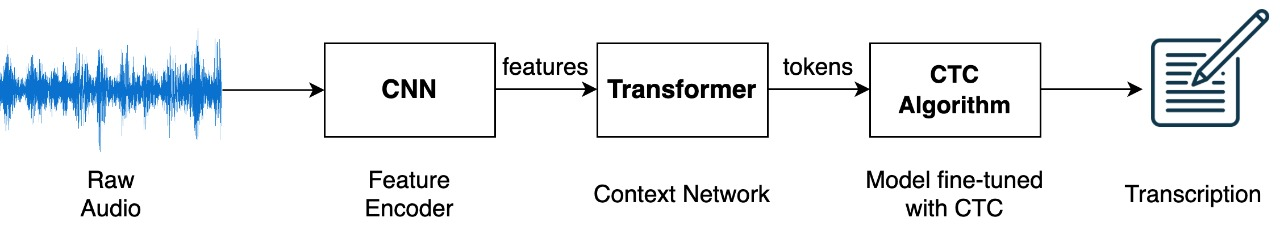

**our steps**:

The process of speech recognition looks like the following.

* Extract the acoustic features from audio waveform
* Estimate the class of the acoustic features frame-by-frame
* Generate hypothesis from the sequence of the class probabilities

Torchaudio provides easy access to the pre-trained weights and associated information, such as the expected sample rate and class labels. They are bundled together and available under torchaudio.pipelines() module.

##**Load Data**

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d ahmedsalamas/speechdata

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
#unzip the speechdata
!unzip /content/speechdata.zip

In [ ]:
# Import needed libraries. 
# %matplotlib inline
import os
import IPython
import matplotlib
import requests
import torch
import torchaudio
%matplotlib inline
import sklearn
import matplotlib.pyplot as plt
import librosa.display
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]
import pandas as pd

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "/content/wavs"  # noqa: E501
SPEECH_FILE = "/content/wavs/LJ001-0010.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

1.11.0+cu113
0.11.0+cu113
cpu


##**Task 1:**
Basic data exploration

Select one randomly sampled wav file in the given folder, perform the following analysis:

1) Print the shape of the picked waveform

2) Print the sample rate of the waveform. 

3) Visualize the waveform using matplotlib

4) Create the spectrogram representation of the picked waveform and visualize it. 

5) Create the MFCC representation of the picked waveform and visualize it.

Reference: https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration/notebook 

Creating a pipeline
First, we will create a **Wav2Vec2** model that performs the **feature extraction and the classification**.

We will use **torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H()**

In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically fetch the pre-trained weights and load it into the model.

In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [ ]:
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (2): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (3): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (4): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
      (6): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjec

###**Loading data**

To load data, we use **torchaudio.load()**

In [ ]:
IPython.display.Audio(SPEECH_FILE)

In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

###**1.1) Print the shape of the picked waveform**

In [ ]:
print("the shape of the picked waveform: {}".format(waveform.size()))

the shape of the picked waveform: torch.Size([1, 194461])


###**1.2) Print the sample rate of the waveform**

In [ ]:
print("the sample rate of the waveform: {}".format(sample_rate))

the sample rate of the waveform: 22050


If the **sampling rate** is different from what the pipeline expects, then we can use **torchaudio.functional.resample()** for resampling.

In [ ]:
if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

###**1.3) Visualize the waveform using matplotlib**

In [ ]:
x , sr = librosa.load(SPEECH_FILE)

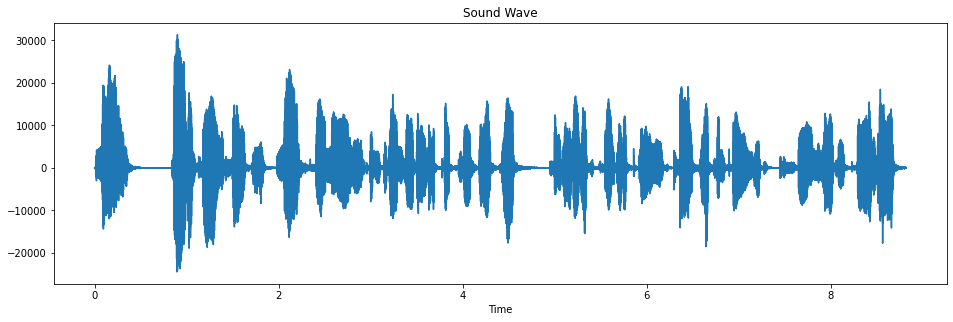

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import wave, sys

# shows the sound waves
def visualize(path: str):

	# reading the audio file
	raw = wave.open(SPEECH_FILE)
	
	# reads all the frames
	# -1 indicates all or max frames
	signal = raw.readframes(-1)
	signal = np.frombuffer(signal, dtype ="int16")
	
	# gets the frame rate
	f_rate = raw.getframerate()

	# to Plot the x-axis in seconds
	# you need get the frame rate
	# and divide by size of your signal
	# to create a Time Vector
	# spaced linearly with the size
	# of the audio file
	time = np.linspace(
		0, # start
		len(signal) / f_rate,
		num = len(signal)
	)

	# using matplotlib to plot
	# creates a new figure
	plt.figure(1)
	
	# title of the plot
	plt.title("Sound Wave")
	
	# label of x-axis
	plt.xlabel("Time")
	
	# actual plotting
	plt.plot(time, signal)
	
	# shows the plot
	# in new window
	plt.show()

	# you can also save
	# the plot using
	# plt.savefig('filename')


if __name__ == "__main__":

	# gets the command line Value
	path = sys.argv[1]

	visualize(path)


###**1.4) Create and Visualize the Spectrogram**

We can also display a spectrogram using **librosa.display.specshow**.

Visualizing data with a spectrogram helps reveal hidden insights in the audio data that may have been less apparent in the traditional waveform representations, allowing us to distinguish noise from the true audio data we wish to interpret. By visualizing audio data this way we can get a clear picture of the imperfections or underlying issues present, helping to guide our analysis and repair of the audio

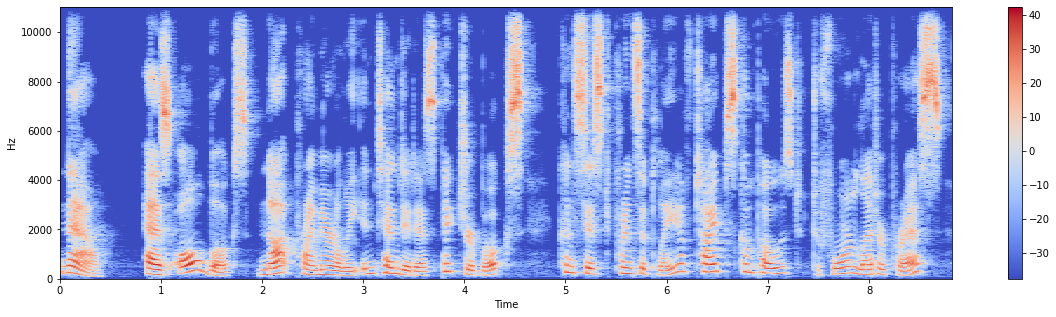

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

###**1.5) Create and Visualize the MFCC**
**Mel-Frequency Cepstral Coefficients** (MFCC):
It is the most widely used audio feature extraction technique. It is a representation of the short-term power spectrum of a sound. Mel-frequency cepstral — inverse Fourier transform of the logarithm of the estimated signal spectrum — coefficients are coefficients that collectively make up an MFC. They are derived from a type of cepstral representation of the audio clip on the mel-scale.

(20, 380)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:255: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  "Numerical issues were encountered "


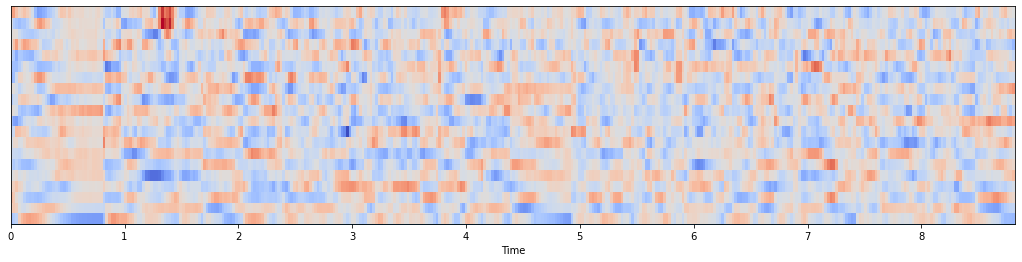

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn

plt.rcParams['figure.figsize'] = (18,4)

x, fs = librosa.load(SPEECH_FILE)
librosa.display.waveplot(x, sr=fs)

mfccs = librosa.feature.mfcc(x, sr=fs)
print(mfccs.shape)
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

## **Task 2**: 
Creating a Wav2Vec2 model that can perform feature extraction and classification.


**Wav2Vec2** models fine-tuned for ASR task can perform **feature extraction and classification** with one step

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
emission

tensor([[[14.8424, -1.2557, -1.1712,  ..., -8.1054, -8.7289, -8.1272],
         [15.0447, -0.5454, -1.3938,  ..., -8.0387, -8.6490, -7.6336],
         [14.6421, -0.0955, -1.0559,  ..., -8.1899, -8.2012, -7.1444],
         ...,
         [14.9286, -1.2978, -2.6482,  ..., -6.7300, -7.6143, -8.1936],
         [14.9275, -1.2996, -2.6460,  ..., -6.7314, -7.6148, -8.1941],
         [14.9879, -0.5352, -1.4119,  ..., -7.9942, -8.5290, -7.9057]]])

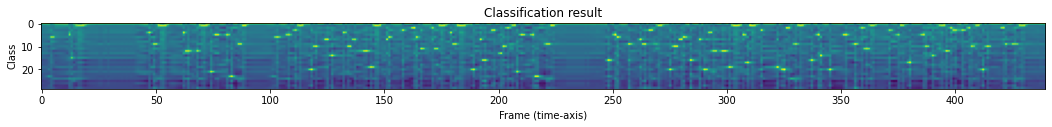

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

## **Task 3:**
 Extract acoustic features and generate predicted transcript for each waveform in the given dataset

The next step is to **extract acoustic features** from the audio.

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

The returned **features** is a list of tensors. Each **tensor** is the output of a **transformer layer**.



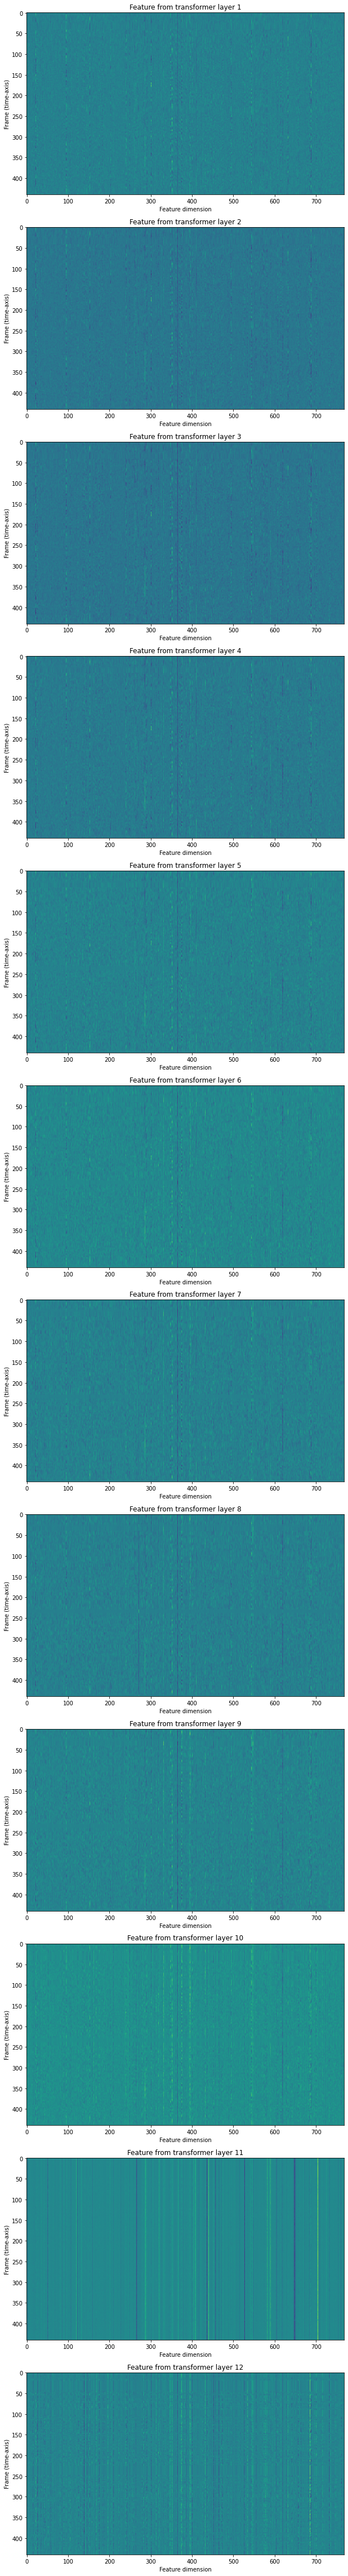

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 5.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

**Generating transcripts**

From the sequence of label probabilities, now we want to generate transcripts. The process to generate hypotheses is often called “**decoding**”.

**Decoding** is more elaborate than simple classification because decoding at certain time step can be affected by surrounding observations.

we will perform **greedy decoding** which does not depend on such external components, and simply pick up the best hypothesis at each time step. Therefore, the context information are not used, and only one transcript can be generated.

In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

Now create the **decoder object** and decode the transcript.



In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

Let’s check the result and listen again to the audio.



In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

NOW|AS|ALL|BOOKS|NOT|PRIMARILY|INTENDED|AS|PICTURE|BOOKS|CONSIST|PRINCIPALLY|OF|TYPES|COMPOSED|TO|FORM|LETTER|PRESS|


to do all last steps on all dataset i will **generate function**
called **audio_text**, it take the speech files and covert it to text   

In [ ]:
def audio_text(SPEECH_FILE):

  waveform, sample_rate = torchaudio.load(SPEECH_FILE)
  waveform = waveform.to(device)

  if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

  with torch.inference_mode():
    emission, _ = model(waveform)

  decoder = GreedyCTCDecoder(labels=bundle.get_labels())
  transcript = decoder(emission[0])

  hypotheses= transcript.replace('|'," ")
  audio =IPython.display.Audio(SPEECH_FILE)
  return hypotheses 

load files names

In [ ]:
import os
files = os.listdir('/content/wavs')
audio_url= np.sort(files)
len(audio_url)

100

call audio_text function and path speech files url to it 

In [ ]:
transcripts=[]
for audio in range(len(audio_url)):
  transcript = audio_text(os.path.join('/content/wavs',audio_url[audio] ))
  transcripts.append(transcript)

In [ ]:
# print the hypotheses
transcripts

['PRINTING IN THE ONLY SENSE WITH WHICH WE ARE AT PRESENT CONCERNED DIFFERS FROM MOST IF NOT FROM ALL THE ARTS AND CRAFTS REPRESENTED IN THE EXHIBITION ',
 'IN BEING COMPARATIVELY MODERN ',
 'FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS ',
 'PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDIATE PREDECESSORS OF THE TRUE PRINTED BOOK ',
 'THE INVENTION OF MOVABLE METAL LETTERS IN THE MIDDLE OF THE FIFTEENTH CENTURY MAY JUSTLY BE CONSIDERED AS THE INVENTION OF THE ART OF PRINTING ',
 'AND IT IS WORTH MENTION IN PASSING THAT AS AN EXAMPLE OF FINE TYPOGRAPHY ',
 'THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES THE GUTTENBERG OR FORTY TWO LINE BIBLE OF ABOUT FOURTEEN FIFTY FIVE ',
 'HAS NEVER BEEN SURPASSED ',
 'PRINTING THEN FOR OUR PURPOSE MAY BE CONSIDERED AS THE ART OF MAKING BOOKS BY MEANS OF MOVABLE TYPES ',
 'NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PICTURE BOOKS CONSIST PRINCIPAL

## **Task 4:**
evaluate the performance of the trained model on the testing dataset using Word Error Rate (WER), Match Error Rate (MER)

Hint: consider this package, https://pypi.org/project/jiwer/

****
**JiWER**

This repository contains a simple python package to approximate the **Word Error Rate** (WER), **Match Error Rate** (MER), **Word Information Lost** (WIL) and **Word Information Preserved** (WIP) of a transcript. It computes the minimum-edit distance between the ground-truth sentence and the hypothesis sentence of a speech-to-text API. 
****

**Installing jiwer library**
****

In [ ]:
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Load labels dataset**
****

In [ ]:
labeled_data=pd.read_csv("/content/labels.csv",engine='python', error_bad_lines=False , header=None ,sep='|' )

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
labeled_data.shape

(523, 3)

In [ ]:
Hypothesis_Truth= labeled_data.iloc[0:100,0:2]
Hypothesis_Truth

0                                                  1
0   LJ001-0001  Printing, in the only sense with which we are ...
1   LJ001-0002                     in being comparatively modern.
2   LJ001-0003  For although the Chinese took impressions from...
3   LJ001-0004  produced the block books, which were the immed...
4   LJ001-0005  the invention of movable metal letters in the ...
..         ...                                                ...
95  LJ001-0096  have now come into general use and are obvious...
96  LJ001-0097  a little reduced in ugliness. The design of th...
97  LJ001-0098  and the whole effect is a little too gray, owi...
98  LJ001-0099  It must be remembered, however, that most mode...
99  LJ001-0100  and these somewhat wiry letters are suitable f...

[100 rows x 2 columns]

**Rename columns header**
****

In [ ]:
Hypothesis_Truth.rename(columns = {0:'File_Name', 1:'Ground_Truth'}, inplace = True)

**Adding transcripts to the table**
****


In [ ]:
Hypothesis_Truth['Hypothesis']= transcripts

In [ ]:
Hypothesis_Truth.head()

File_Name                                       Ground_Truth  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-0005  the invention of movable metal letters in the ...   

                                          Hypothesis  
0  PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...  
1                     IN BEING COMPARATIVELY MODERN   
2  FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...  
3  PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...  
4  THE INVENTION OF MOVABLE METAL LETTERS IN THE ...

****
**Pre-processing**
****
* It might be necessary to apply some pre-processing steps on either the hypothesis or ground truth text. This is possible with the transformation API.
* **Compose** can be used to combine multiple transformations.
* **ToLowerCase**
jiwer.ToLowerCase() can be used to convert every character into lowercase.
* **ReduceToListOfListOfWords** jiwer.ReduceToListOfListOfWords(word_delimiter=" ") can be used to transform one or more sentences into a list of lists of words. The sentences can be given as a string (one sentence) or a list of strings (one or more sentences). This operation should be the final step of any transformation pipeline as the library internally computes the word error rate based on a double list of words.

* **RemoveWhiteSpace**
jiwer.RemoveWhiteSpace(replace_by_space=False) can be used to filter out white space. The whitespace characters are , \t, \n, \r, \x0b and \x0c. Note that by default space ( ) is also removed, which will make it impossible to split a sentence into words by using SentencesToListOfWords. This can be prevented by replacing all whitespace with the space character.

* **RemovePunctuation** jiwer.RemovePunctuation() can be used to filter out punctuation. The punctuation characters are:
'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

* **RemoveMultipleSpaces**
jiwer.RemoveMultipleSpaces() can be used to filter out multiple spaces between words

* **ExpandCommonEnglishContractions**
jiwer.ExpandCommonEnglishContractions() can be used to replace common contractions such as let's to let us.
****

In [ ]:
import jiwer

ground_truth = list(Hypothesis_Truth['Ground_Truth'])
hypothesis = transcripts

transformation = jiwer.Compose([
    jiwer.ToLowerCase(),
    jiwer.RemoveWhiteSpace(replace_by_space=True),
    jiwer.RemoveMultipleSpaces(),
    jiwer.ExpandCommonEnglishContractions(),
    jiwer.RemovePunctuation(),
    jiwer.RemoveKaldiNonWords(),
    jiwer.ReduceToListOfListOfWords(word_delimiter=" ")
]) 

****
**Word Error Rate** (WER) is a common metric of the performance of a speech recognition or machine translation system.

The general difficulty of measuring performance lies in the fact that the recognized word sequence can have a different length from the reference word sequence (supposedly the correct one). The WER is derived from the Levenshtein distance, working at the word level instead of the phoneme level. The WER is a valuable tool for comparing different systems as well as for evaluating improvements within one system. This kind of measurement, however, provides no details on the nature of translation errors and further work is therefore required to identify the main source(s) of error and to focus any research effort.

This problem is solved by first aligning the recognized word sequence with the reference (spoken) word sequence using dynamic string alignment. Examination of this issue is seen through a theory called the power law that states the correlation between perplexity and word error rate
****

****
**Word error rate** can then be computed as:
****
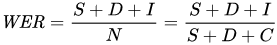
****
where

* S is the number of substitutions,
* D is the number of deletions,
* I is the number of insertions,
* C is the number of correct words,
* N is the number of words in the reference (N=S+D+C)
****

In [ ]:
WER=[]
for i in range(len(Hypothesis_Truth)):
  wer= jiwer.wer(
      ground_truth[i], 
      hypothesis[i], 
      truth_transform=transformation, 
      hypothesis_transform=transformation
  )
  WER.append(wer)

****

In [ ]:
MER=[]
for i in range(len(Hypothesis_Truth)):
  mer= jiwer.mer(
    ground_truth, 
    hypothesis, 
    truth_transform=transformation, 
    hypothesis_transform=transformation
  )
  MER.append(mer)

In [ ]:
Hypothesis_Truth['WER']= WER
Hypothesis_Truth['MER']= MER

In [ ]:
Hypothesis_Truth.head()

File_Name                                       Ground_Truth  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-0005  the invention of movable metal letters in the ...   

                                          Hypothesis       WER       MER  
0  PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...  0.000000  0.070893  
1                     IN BEING COMPARATIVELY MODERN   0.000000  0.070893  
2  FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM...  0.083333  0.070893  
3  PRODUCED THE BLOCK BOOKS WHICH WERE THE IMMEDI...  0.000000  0.070893  
4  THE INVENTION OF MOVABLE METAL LETTERS IN THE ...  0.000000  0.070893

## **Task 5:** 
check files with **the worst performance** and perform a simple error analysis, e.g., what are the files having worser performance, and what are the potential reasons, do they share any common patterns?


****

The **best achievable WER score is 0**, which means that every word is transcribed correctly with no inserted words.
****

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['WER']>=0.25]

File_Name                                       Ground_Truth  \
6   LJ001-0007  the earliest book printed with movable types, ...   
23  LJ001-0024  But the first Bible actually dated (which also...   
30  LJ001-0031  In 1465 Sweynheim and Pannartz began printing ...   
37  LJ001-0038  while in 1470 at Paris Udalric Gering and his ...   
44  LJ001-0045                                        1469, 1470;   
54  LJ001-0055  some of which -- as, e.g., that of Jacobus Rub...   
80  LJ001-0081  type cast from his matrices is still in everyd...   
91  LJ001-0092  The Chiswick press in 1844 revived Caslon's fo...   

                                           Hypothesis       WER       MER  
6   THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES T...  0.375000  0.070893  
23  BUT THE FIRST BIBLE ACTUALLY DATED WHICH ALSO ...  0.263158  0.070893  
30  IN FOURTEEN SIXTY FIVE SWAYNHEIM AND PANARCHS ...  0.357143  0.070893  
37  WHILE IN FOURTEEN SEVENTY AT PARIS UDORICH GER...  0.272727  0.070893  
44              FOURTEEN SIXTY NINE FOURTEEN SEVENTY   2.500000  0.070893  
54  SOME OF WHICH AS E G THAT OF JACOBIS RUBIUS OR...  0.277778  0.070893  
80  TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY...  0.300000  0.070893  
91  THE CHISWICK PRESS IN EIGHTEEN FORTY FOUR REVI...  0.333333  0.070893

****
The files that have **worser performance**
as show in last cell code which have more than .25 WER 
 and the potential reasons come from the numbers when the record contains numbers , yes they share common patterns 
 

In [ ]:
Hypothesis_Truth.iloc[2,:]['Ground_Truth']

'For although the Chinese took impressions from wood blocks engraved in relief for centuries before the woodcutters of the Netherlands, by a similar process'

In [ ]:
Hypothesis_Truth.iloc[2,:]['Hypothesis']

'FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE WOOD CUTTERS OF THE NETHERLANDS BY A SIMILAR PROCESS '

****
In speach name "LJ001-0003"
The term **woodcutters** is spelled as a single compound word in the reference, but as two words in the hypothesis:

* Ground_truth : For although the Chinese took impressions from wood blocks engraved in relief for centuries before the **woodcutters** of the Netherlands, by a similar process.
* Hypothesis : FOR ALTHOUGH THE CHINESE TOOK IMPRESSIONS FROM WOOD BLOCKS ENGRAVED IN RELIEF FOR CENTURIES BEFORE THE **WOOD CUTTERS** OF THE NETHERLANDS BY A SIMILAR PROCESS 
****

In [ ]:
print('the truth     value of the file name LJ001-0081 is: ',Hypothesis_Truth.iloc[80,:]['Ground_Truth'])
print('the predicted value of the file name LJ001-0081 is: ', Hypothesis_Truth.iloc[80,:]['Hypothesis'])

the truth     value of the file name LJ001-0081 is:  type cast from his matrices is still in everyday use.
the predicted value of the file name LJ001-0081 is:  TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY DAY USE 


****
And in the last cell the word **everyday** our model work on it as separated word **every day**
****

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['WER'].idxmax()]

File_Name                                  LJ001-0045
Ground_Truth                              1469, 1470;
Hypothesis      FOURTEEN SIXTY NINE FOURTEEN SEVENTY 
WER                                               2.5
MER                                          0.070893
Name: 44, dtype: object

****
**1469, 1470** is spelled with numerals and a currency symbol in the reference, but the our model system spells it using the alphabet as **FOURTEEN SIXTY NINE FOURTEEN SEVENTY**
****

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['WER']>=.2]

File_Name                                       Ground_Truth  \
6   LJ001-0007  the earliest book printed with movable types, ...   
9   LJ001-0010  Now, as all books not primarily intended as pi...   
23  LJ001-0024  But the first Bible actually dated (which also...   
30  LJ001-0031  In 1465 Sweynheim and Pannartz began printing ...   
37  LJ001-0038  while in 1470 at Paris Udalric Gering and his ...   
44  LJ001-0045                                        1469, 1470;   
54  LJ001-0055  some of which -- as, e.g., that of Jacobus Rub...   
80  LJ001-0081  type cast from his matrices is still in everyd...   
86  LJ001-0087  for the seventeenth-century letters are at lea...   
91  LJ001-0092  The Chiswick press in 1844 revived Caslon's fo...   
92  LJ001-0093  This experiment was so far successful that abo...   

                                           Hypothesis       WER       MER  
6   THE EARLIEST BOOK PRINTED WITH MOVABLE TYPES T...  0.375000  0.070893  
9   NOW AS ALL BOOKS NOT PRIMARILY INTENDED AS PIC...  0.235294  0.070893  
23  BUT THE FIRST BIBLE ACTUALLY DATED WHICH ALSO ...  0.263158  0.070893  
30  IN FOURTEEN SIXTY FIVE SWAYNHEIM AND PANARCHS ...  0.357143  0.070893  
37  WHILE IN FOURTEEN SEVENTY AT PARIS UDORICH GER...  0.272727  0.070893  
44              FOURTEEN SIXTY NINE FOURTEEN SEVENTY   2.500000  0.070893  
54  SOME OF WHICH AS E G THAT OF JACOBIS RUBIUS OR...  0.277778  0.070893  
80  TYPE CAST FROM HIS MATRESSES IS STILL IN EVERY...  0.300000  0.070893  
86  FOR THE SEVENTEENTH CENTURY LETTERS ARE AT LEA...  0.210526  0.070893  
91  THE CHISWICK PRESS IN EIGHTEEN FORTY FOUR REVI...  0.333333  0.070893  
92  THIS EXPERIMENT WAS SO FAR SUCCESSFUL THAT ABO...  0.200000  0.070893

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['MER'].idxmax()]

File_Name                                              LJ001-0001
Ground_Truth    Printing, in the only sense with which we are ...
Hypothesis      PRINTING IN THE ONLY SENSE WITH WHICH WE ARE A...
WER                                                           0.0
MER                                                      0.070893
Name: 0, dtype: object

In [ ]:
Hypothesis_Truth.loc[Hypothesis_Truth['MER']>=0.08]

Empty DataFrame
Columns: [File_Name, Ground_Truth, Hypothesis, WER, MER]
Index: []

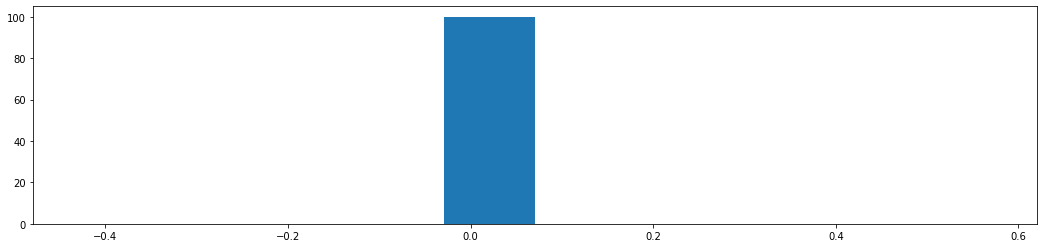

In [ ]:
plt.hist(Hypothesis_Truth['MER']);

from this graph the values of MER around Zero 

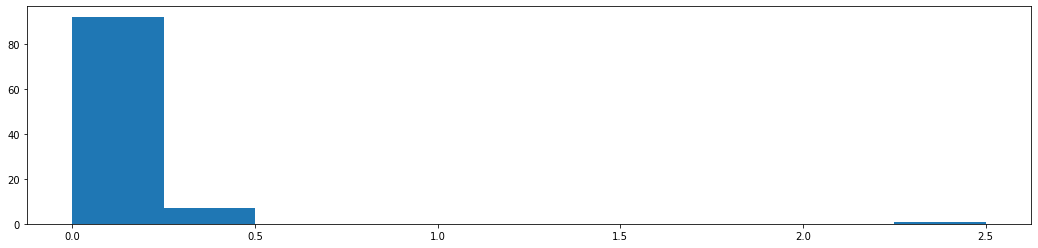

In [ ]:
plt.hist(Hypothesis_Truth['WER']);

but in this graph the values of  **"WER"** between zero and 0.5 and only one record equal 2.5 